In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, Input, regularizers
import keras_tuner

In [3]:

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.3,
  subset="both",
  seed=123,
  image_size=(48, 48),
  batch_size=32,
  color_mode="grayscale",
  shuffle=True
)

Found 35887 files belonging to 7 classes.
Using 25121 files for training.
Using 10766 files for validation.


In [4]:
def tune(hp):
    model = Sequential([
    layers.Rescaling(scale=(1.0 / 255), input_shape=(48, 48, 1)),
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=4),
        kernel_size=(3, 3),
        activation='relu',
        strides=(1, 1)
        ),

    layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding="same"
        ),

    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=48, max_value=128, step=8),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(48,48,1),
        strides=(1, 1)
        ),

    layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding="same"
        ),

    layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=96, max_value=512, step=16),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(48,48,1),
        strides=(1, 1)
        ),

    layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding="same"
        ),
    
    layers.Flatten(),

    layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=512, step=16),
        activation='relu'
    ),

    layers.Dense(
        units=hp.Int('dense_2_units', min_value=128, max_value=512, step=16),
        activation='relu'
    ),

    layers.Dropout(rate=hp.Float('dropout', min_value=0, max_value=0.7, step=0.1)),

    layers.Dense(7, activation='softmax')
    ])


    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
tuner = keras_tuner.RandomSearch(
    tune,
    objective='val_loss',
    max_trials=20
)

In [6]:
tuner.search(train_ds, epochs=10, validation_data=val_ds)
best_model = tuner.get_best_models()[0]

Trial 20 Complete [00h 02m 20s]
val_loss: 1.2250016927719116

Best val_loss So Far: 1.2138499021530151
Total elapsed time: 00h 47m 59s
INFO:tensorflow:Oracle triggered exit


In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 52)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 52)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       60032     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 160)         1

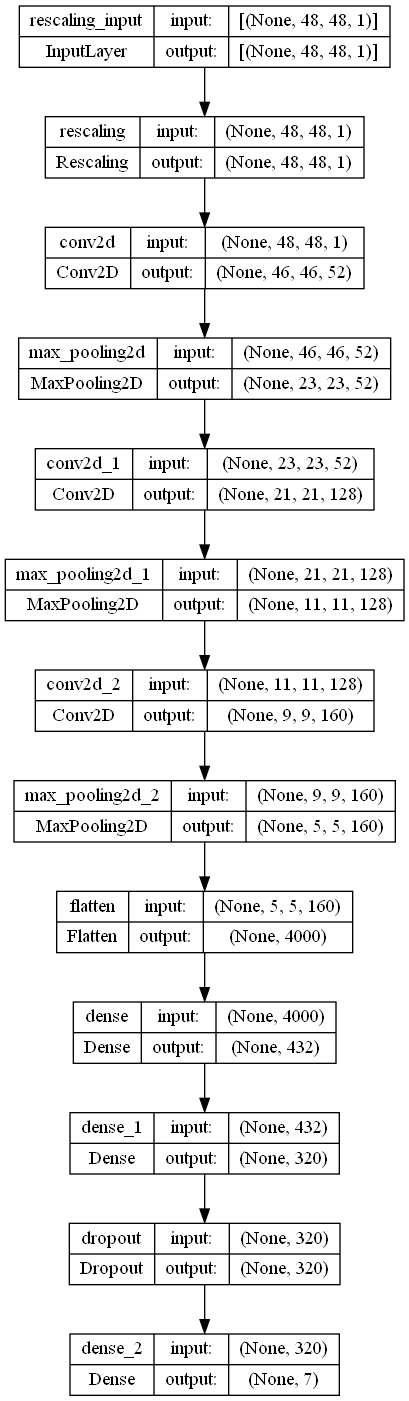

In [8]:
keras.utils.plot_model(best_model, show_shapes=True)

In [9]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
#{'conv_1_filter': 32, 'conv_1_kernel': 3, 'conv_2_filter': 48, 'conv_2_kernel': 3, 'conv_3_filter': 176, 'conv_3_kernel': 3, 'dense_1_units': 224, 'dense_2_units': 272, 'dropout': 0.6000000000000001, 'learning_rate': 0.001}

{'conv_1_filter': 52, 'conv_2_filter': 128, 'conv_3_filter': 160, 'dense_1_units': 432, 'dense_2_units': 320, 'dropout': 0.1, 'learning_rate': 0.001}
